Found 8000 files belonging to 1 classes.
Using 6400 files for training.
Found 8000 files belonging to 1 classes.
Using 1600 files for validation.


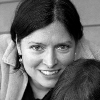

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


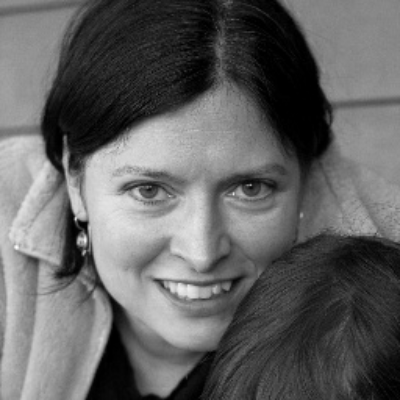

In [12]:
# Setup
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL

def scale01(img): 
    return img/255

def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    
    return tf.image.resize(y,[img_size,img_size],method='bicubic')

def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    
    return y

# Loading and preparing the dataset
train_high_ds = '/home/cst2/preprocessed_data/train/resized_ds'
validate_high_ds = '/home/cst2/preprocessed_data/validate/resized_ds'

[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8

train_ds=image_dataset_from_directory(
    train_high_ds,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)

valid_ds=image_dataset_from_directory(
    validate_high_ds,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=1234,label_mode=None,)

train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
        
test_path='/home/cst2/preprocessed_data/test/resized_ds/resized'
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])

train_ds=train_ds.map(lambda x: (process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)

valid_ds=valid_ds.map(lambda x: (process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)

for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break
        
# Building the model
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,1))
    
    x1 = layers.Conv2D(64, (3, 3), **conv_args)(inputs)
    x1 = layers.Conv2D(64, (3, 3), **conv_args)(x1)

    x = layers.MaxPooling2D((2, 2))(x1) 

    x2 = layers.Conv2D(128, (3, 3), **conv_args)(x)
    x2 = layers.Conv2D(128, (3, 3), **conv_args)(x2)

    x = layers.MaxPooling2D((2, 2))(x2)

    x3 = layers.Conv2D(256, (3, 3), **conv_args)(x)

    x = layers.UpSampling2D()(x3)

    x2_2 = layers.Conv2D(128, (3, 3), **conv_args)(x)
    x2_2 = layers.Conv2D(128, (3, 3), **conv_args)(x2_2)

    m1 = layers.Add()([x2, x2_2])
    m1 = layers.UpSampling2D()(m1)

    x1_2 = layers.Conv2D(64, (3, 3), **conv_args)(m1)
    x1_2 = layers.Conv2D(64, (3, 3), **conv_args)(x1_2)

    m2 = layers.Add()([x1, x1_2])

    x = layers.Conv2D(16, (3, 3), activation='linear', padding='same')(m2)

    x = tf.nn.depth_to_space(x, upscale_factor)
    
    return tf.keras.Model(inputs,x)

# Utility functions
## Displaying results
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    pl.show()

## Low resolution images
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,img.size[1]//upscale_factor)
    
    return img.resize(dimensions,PIL.Image.BICUBIC,)

## Upscaled Images
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape((np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge('YCbCr',(out_img_y,out_img_cb,out_img_cr))
    
    return out_img.convert('RGB')

## Callback class with functions on epoch begin, end, and testing batch end
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))


In [13]:
# Using Early Stopping 
early_stopping=tkc.EarlyStopping(monitor='loss',verbose=2,patience=10)

# Saving weights and checkpoints
checkpoint_path='/home/cst2/Testing Code/checkpoint/final'

checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)

lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',patience=10,verbose=2,factor=.9)

model=model(upscale_factor=upscale_factor,channels=1)

# Summary of the network architecture
model.summary()

callbacks=[ESPCNCallback(),early_stopping,checkpoint,lr_reduction]

loss_fn=tf.keras.losses.MeanSquaredError()
# Setting the optimizer and learning rate 
optimizer=tf.keras.optimizers.Adam(learning_rate=.0001)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, None, None, 6 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, None, None, 6 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, None, None, 6 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [14]:
epochs=50

model.compile(optimizer=optimizer,loss=loss_fn,metrics=['accuracy'],)

history=model.fit(train_ds,epochs=epochs,callbacks=callbacks,validation_data=valid_ds,verbose=2)

model.load_weights(checkpoint_path)

Epoch 1/50
800/800 - 39s - loss: 0.0071 - accuracy: 0.0044 - val_loss: 0.0011 - val_accuracy: 0.0042
mean PSNR for epoch: 29.68

Epoch 00001: loss improved from inf to 0.00711, saving model to /home/cst2/Testing Code/checkpoint/final
Epoch 2/50
800/800 - 39s - loss: 9.8924e-04 - accuracy: 0.0045 - val_loss: 9.5320e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 30.08

Epoch 00002: loss improved from 0.00711 to 0.00099, saving model to /home/cst2/Testing Code/checkpoint/final
Epoch 3/50
800/800 - 38s - loss: 9.2816e-04 - accuracy: 0.0045 - val_loss: 9.1826e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 30.24

Epoch 00003: loss improved from 0.00099 to 0.00093, saving model to /home/cst2/Testing Code/checkpoint/final
Epoch 4/50
800/800 - 39s - loss: 8.9783e-04 - accuracy: 0.0045 - val_loss: 8.9283e-04 - val_accuracy: 0.0042
mean PSNR for epoch: 30.43

Epoch 00004: loss improved from 0.00093 to 0.00090, saving model to /home/cst2/Testing Code/checkpoint/final
Epoch 5/50
800/800 - 38s - l

PSNR of low resolution and high resolution is 27.8445
PSNR of predict and high resolution is 28.0565


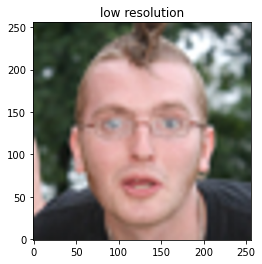

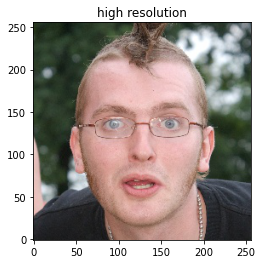

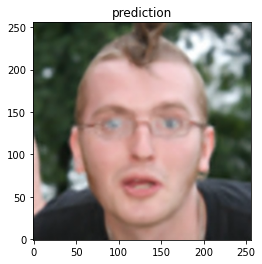

PSNR of low resolution and high resolution is 29.3396
PSNR of predict and high resolution is 29.4118


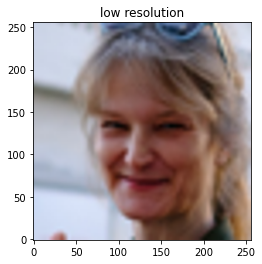

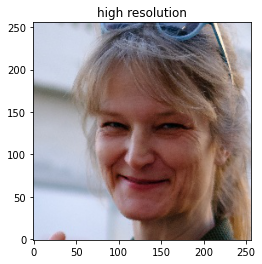

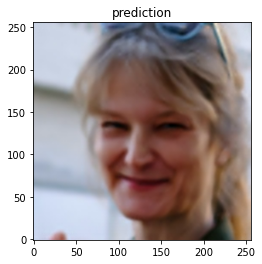

PSNR of low resolution and high resolution is 31.3522
PSNR of predict and high resolution is 31.1406


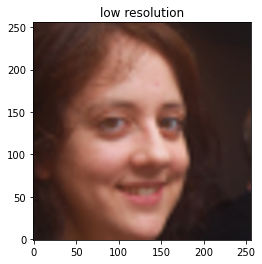

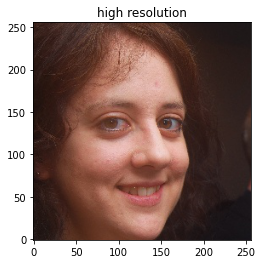

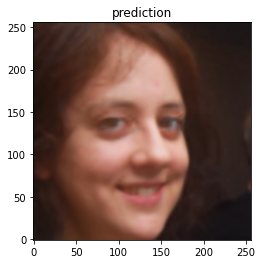

PSNR of low resolution and high resolution is 25.2907
PSNR of predict and high resolution is 25.5093


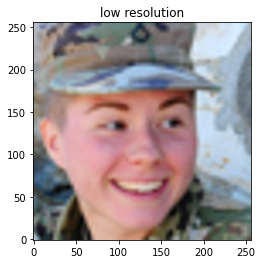

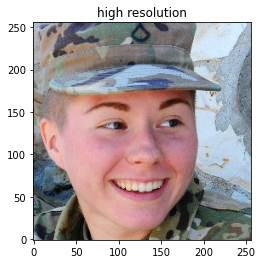

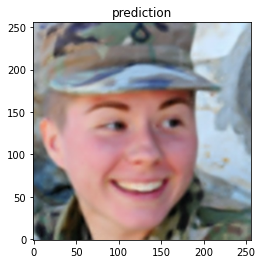

PSNR of low resolution and high resolution is 23.0942
PSNR of predict and high resolution is 23.2452


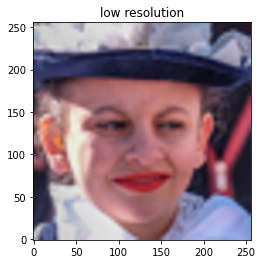

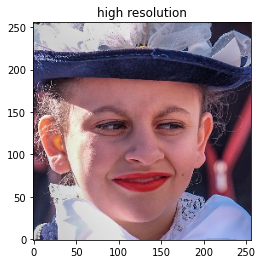

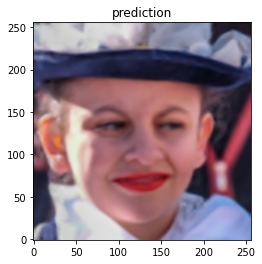

PSNR of low resolution and high resolution is 26.1059
PSNR of predict and high resolution is 26.5381


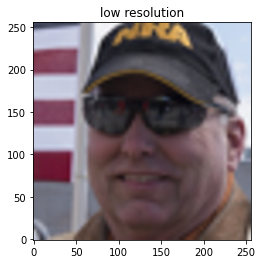

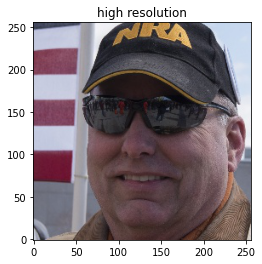

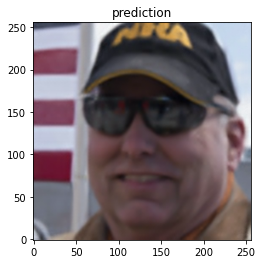

PSNR of low resolution and high resolution is 28.7635
PSNR of predict and high resolution is 28.8004


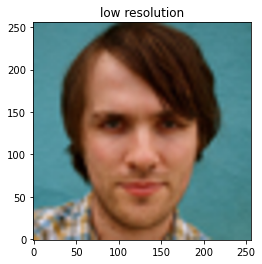

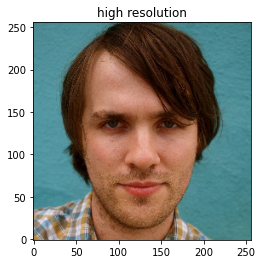

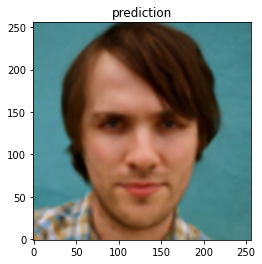

PSNR of low resolution and high resolution is 26.2598
PSNR of predict and high resolution is 26.3769


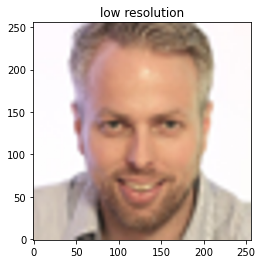

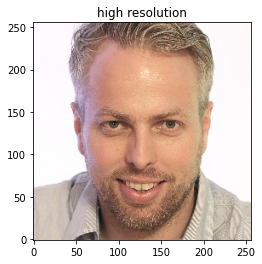

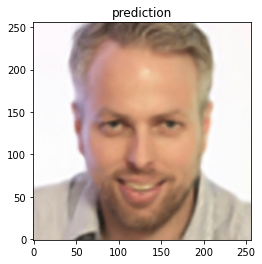

PSNR of low resolution and high resolution is 28.6791
PSNR of predict and high resolution is 28.7761


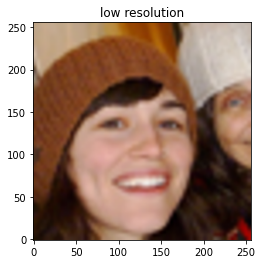

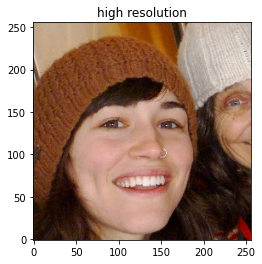

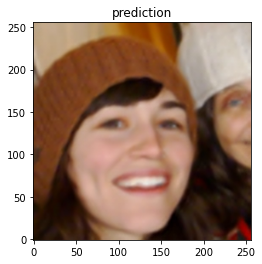

PSNR of low resolution and high resolution is 25.0011
PSNR of predict and high resolution is 25.2425


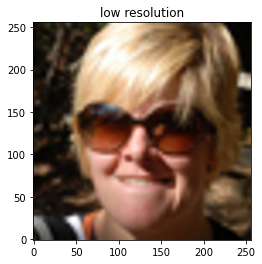

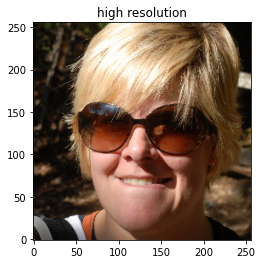

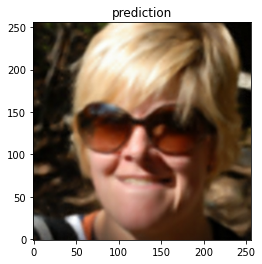

avg. PSNR of images with low resolution is 27.1731
avg. PSNR of reconstructions is 27.3097


In [16]:
total_bicubic_psnr=0. 
total_test_psnr=0.
n_img=10

for index,test_path in enumerate(test_paths[0:n_img]):
    
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    
    highres_img=img.resize((w,h))
    
    predict_img=upscale_img(model,lowres_input)
    
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    
    highres_img_arr=img_to_array(highres_img)
    
    predict_img_arr=img_to_array(predict_img)
    
    bicubic_psnr=tf.image.psnr(lowres_img_arr,highres_img_arr,max_val=255)
    
    test_psnr=tf.image.psnr(predict_img_arr,highres_img_arr,max_val=255)
    
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    
    print('PSNR of low resolution and high resolution is %.4f' %bicubic_psnr)
    
    print('PSNR of predict and high resolution is %.4f' %test_psnr)
    
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
    
print('avg. PSNR of images with low resolution is %.4f' %(total_bicubic_psnr/n_img))

print('avg. PSNR of reconstructions is %.4f' %(total_test_psnr/n_img))